In [9]:
import numpy as np
import math
import pandas as pd

from geneticalgorithm2 import geneticalgorithm2 as ga # for creating and running optimization mode
from geneticalgorithm2 import Generation, AlgorithmParams # classes for comfortable parameters setting and getting
from geneticalgorithm2 import Crossover, Mutations, Selection # classes for specific mutation and crossover behavior
from geneticalgorithm2 import Population_initializer # for creating better start population
from geneticalgorithm2 import np_lru_cache # for cache function (if u want)
from geneticalgorithm2 import plot_pop_scores # for plotting population scores, if u want
from geneticalgorithm2 import Actions, ActionConditions, MiddleCallbacks # middle callbacks

In [22]:
 #read the csv file (put 'r' before the path string to address any special characters in the path, such as '\'). Don't forget to put the file name at the end of the path + ".csv"
data = pd.read_csv ('data_6_3_LINGO.csv')
df = pd.DataFrame(data)

b3 = df[["B3"]].to_numpy()
b4 = df[["B4"]].to_numpy()
b5 = df[["B5"]].to_numpy()

# profit contribution per 1000 feet
profits = [15.89, 17.89, 16.5, 15.22, 17.5, 16.22]

cota_maxima_benef = profits[0]*315 + profits[1]*315 + profits[2]*210 + profits[3]*157.5 + profits[4]*210 + profits[5]*157.5
cota_maxima_1000s = 315+315+210+157.5+210+157.5

In [86]:
def f(X):
    pen = 0
    if 1000/(b3[0]*60)*X[0] + 1000/(b3[0]*60)*X[1] > b3[1]:
        pen += cota_maxima_benef + 10000*(1000/(b3[0]*60)*X[0] + 1000/(b3[0]*60)*X[1] - b3[1])
    if 1000/(b4[0]*60)*X[2] + 1000/(b4[0]*60)*X[4] > b4[1]:
        pen += cota_maxima_benef + 10000*(1000/(b4[0]*60)*X[2] + 1000/(b4[0]*60)*X[4] - b4[1])
    if 1000/(b5[0]*60)*X[3] + 1000/(b5[0]*60)*X[5] > b5[1]:
        pen += cota_maxima_benef + 10000*(1000/(b5[0]*60)*X[3] + 1000/(b5[0]*60)*X[5] - b5[1])
    if X[0]+X[1]+X[2]+X[3]+X[4]+X[5] > 600:
        pen += cota_maxima_benef + 10000*(X[0]+X[1]+X[2]+X[3]+X[4]+X[5] - 600)
    if X[1] + X[2] + X[3] < 114:
        pen += (315+210+157.5) + 10000*abs(X[1] + X[2] + X[3] - 114)
    if X[4] + X[5] < 111:
        pen += (210+157.5) + 10000*abs(X[4] + X[5] - 111)
        
    res = int(profits[0]*X[0]) + int(profits[1]*X[1]) + int(profits[2]*X[2]) + int(profits[3]*X[3]) + int(profits[4]*X[4]) + int(profits[5]*X[5]) - int(pen)
    return -res
    

In [99]:
algorithm_param = {'max_num_iteration': 6000,\
                   'population_size': 200,\
                   'mutation_probability':0.5,\
                   'elit_ratio': 0.0,\
                   'parents_portion': 0.3,\
                   'crossover_type':'one_point',\
                   'mutation_type':'gauss_by_center',\
                   'selection_type':'tournament',\
                   'max_iteration_without_improv':None}


Average time of function evaluating (secs): 0.0005010032653808594 (total = 0.10020065307617188)

Best score before optimization: -8078.0
                                                                                                                                                                                                        
 The best found solution:
 [221.85320091  93.0527165   16.01952624   7.16389183 193.7009004
  68.17439637]

 Objective function:
 -10056.0

 Used generations: 6000
 Used time: 139 seconds


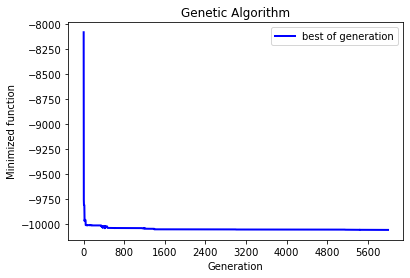

In [100]:
import time

#              B34      B38     B48      B58      B42      B52
varbound = [[218,315],[0,315],[0,210],[0,157.5],[0,210],[0,157.5]]

model=ga(function=f,dimension=6,variable_type='real',variable_boundaries=varbound, algorithm_parameters=algorithm_param)

result = model.run()

## Aplicar descenso de gradiente

In [101]:
import matplotlib
import matplotlib.pyplot as plt
import sklearn.datasets as dt
from sklearn.model_selection import train_test_split

In [ ]:
# Make threshold a -ve value if you want to run exactly
# max_iterations.
def gradient_descent(max_iterations,threshold,w_init,
                     obj_func,grad_func,extra_param = [],
                     learning_rate=0.05,momentum=0.8):
    
    w = w_init
    w_history = w
    f_history = obj_func(w,extra_param)
    delta_w = np.zeros(w.shape)
    i = 0
    diff = 1.0e10
    
    while  i<max_iterations and diff>threshold:
        delta_w = -learning_rate*grad_func(w,extra_param) + momentum*delta_w
        w = w+delta_w
        
        # store the history of w and f
        w_history = np.vstack((w_history,w))
        f_history = np.vstack((f_history,obj_func(w,extra_param)))
        
        # update iteration number and diff between successive values
        # of objective function
        i+=1
        diff = np.absolute(f_history[-1]-f_history[-2])
    
    return w_history,f_history